In [1]:
import os
import ast
import torch
import scienceplots
import pickle as pkl
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
from plot_utils import plot_behavior_distribution
from data_utils import (
    results2df,
)
from torchmetrics.functional.classification import (
    multilabel_average_precision,
    multilabel_f1_score,
)
from matplotlib.colors import rgb2hex

plt.style.use("science")
plt.rcParams.update({"font.family": "Times New Roman"})

**Data Loading**

In [2]:
metadata_file = "/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/dataset/metadata/metadata_with_nv.csv"
behaviours_file = "../dataset/metadata/behaviours.txt"
segments_file = "../dataset/metadata/segments.txt"


metadata_df = pd.read_csv(metadata_file)

with open(behaviours_file, "rb") as f:
    behaviours = [beh.decode("utf-8").strip() for beh in f.readlines()]

with open(segments_file, "rb") as f:
    segments = [seg.decode("utf-8").strip() for seg in f.readlines()]

dummy_aps = [
    0.0235,
    0.0531,
    0.1467,
    0.1292,
    0.0346,
    0.2582,
    0.0776,
    0.1038,
    0.0155,
    0.0115,
    0.4553,
    0.1002,
    0.5724,
    0.0563,
]


exc_dummy_aps = [
    0.0206,
    0.0453,
    0.1432,
    0.1658,
    0.0227,
    0.2533,
    0.0618,
    0.1267,
    0.0175,
    0.0062,
    0.4027,
    0.1432,
    0.62,
    0.0494,
]

**Plot the behaviour distribution for the standard and exclusive datasets**

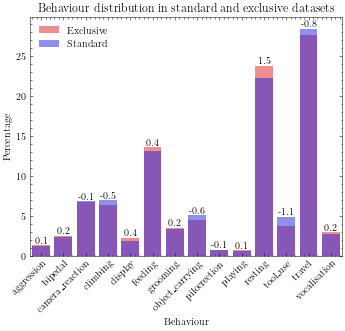

In [12]:
exc_tr_df = pd.read_csv(
    "/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/dataset/annotations/standard/exclusive_utm/train.csv"
)
std_tr_df = pd.read_csv(
    "/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/dataset/annotations/standard/fg_only/standard/train.csv"
)

exc_tr_df.columns = ["name", "name_bg", "label", "negative", "utm"]
exc_tr_df = exc_tr_df[["name", "label"]]

std_tr_df.columns = ["name", "label"]

exc_tr_df["label"] = exc_tr_df["label"].apply(lambda x: ast.literal_eval(x))
std_tr_df["label"] = std_tr_df["label"].apply(lambda x: ast.literal_eval(x))

exc_dist = (
    plot_behavior_distribution(exc_tr_df, behaviours, "percentage", plot=False)
    .sort_values(by="behavior")
    .percentage
)
std_dist = (
    plot_behavior_distribution(std_tr_df, behaviours, "percentage", plot=False)
    .sort_values(by="behavior")
    .percentage
)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Assuming behaviours, exc_dist, and std_dist are defined
bars1 = sns.barplot(
    x=behaviours,
    y=exc_dist,
    color="red",
    label="Exclusive",
    alpha=0.5,
    linewidth=0.5,
    ax=ax,
)
bars2 = sns.barplot(
    x=behaviours,
    y=std_dist,
    color="blue",
    label="Standard",
    alpha=0.5,
    linewidth=0.5,
    ax=ax,
)

plt.xticks(rotation=90)
plt.legend()
plt.ylabel("Percentage")
plt.xlabel("Behaviour")
plt.title("Behaviour distribution in standard and exclusive datasets")

# Calculate and display the differences
for i, (exc, std) in enumerate(zip(exc_dist, std_dist)):
    diff = exc - std
    ax.text(i, max(exc, std), f"{diff:.1f}%", ha="center", va="bottom")

plt.tight_layout()
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
# plt.savefig('behaviour_distribution.pdf')
plt.show()

<Axes: xlabel='behavior'>

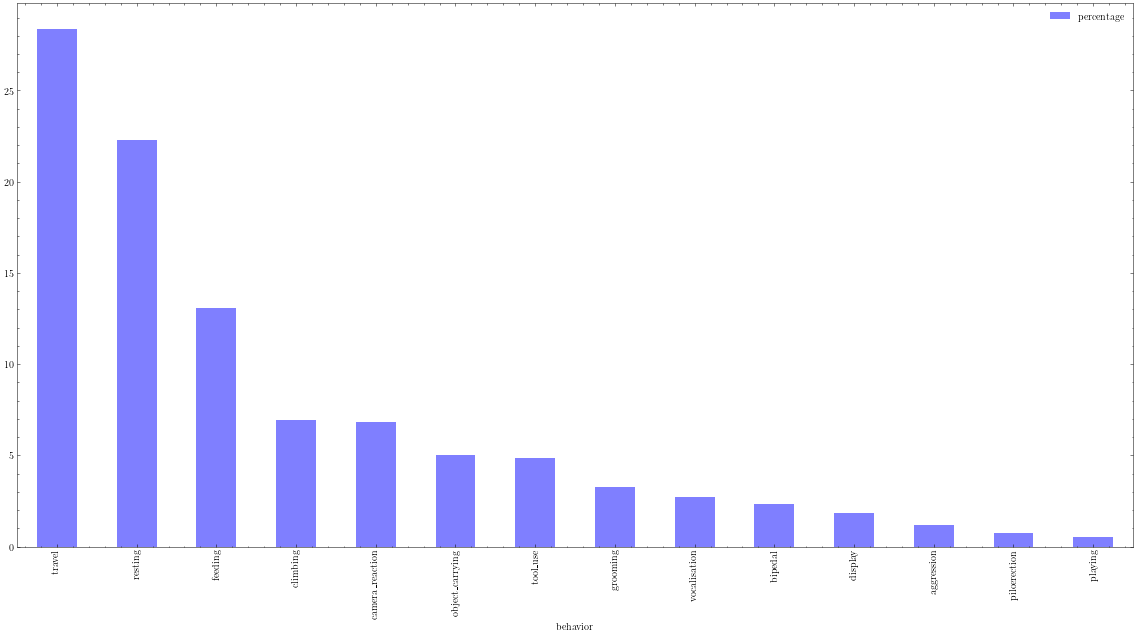

In [17]:
plot_behavior_distribution(std_tr_df, behaviours, "percentage", plot=False).plot(
    kind="bar", x="behavior", y="percentage", color="blue", alpha=0.5, figsize=(20, 10)
)

In [5]:
def calculate_metrics(df, round_to=3, show_per_class=True):
    map_values = multilabel_average_precision(
        torch.tensor(np.stack(df["pred"])),
        torch.tensor(np.stack(df["label"])),
        num_labels=14,
        average="none",
        # thresholds=200,
    )
    avg_map = round(map_values.mean().item(), round_to)
    if show_per_class:
        map_values_list = []
        for v in map_values:
            map_v = round(v.item(), round_to)
            map_values_list.append(map_v)

        return map_values_list
    return avg_map


def calculate_imbalance_measures(df):
    counts = df["count"]
    total_samples = counts.sum()
    scaling_factor = np.log(total_samples)

    # 1. Gini coefficient
    def gini(x):
        x = np.sort(x)
        index = np.arange(1, len(x) + 1)
        return (np.sum((2 * index - len(x) - 1) * x)) / (len(x) * np.sum(x))

    gini_coefficient = gini(counts)

    # 2. Coefficient of variation
    cv = counts.std() / counts.mean()

    # 3. 80-20 rule (Pareto principle)
    sorted_counts = counts.sort_values(ascending=False)
    cumulative_sum = sorted_counts.cumsum()
    percentile_80 = np.interp(
        0.8 * total_samples, cumulative_sum, range(1, len(cumulative_sum) + 1)
    )
    pareto_ratio = percentile_80 / len(counts)

    # 4. Entropy-based measure
    probabilities = counts / total_samples
    entropy = stats.entropy(probabilities)
    max_entropy = np.log(len(counts))
    normalized_entropy = entropy / max_entropy
    imbalance_score = 1 - normalized_entropy

    return {
        "gini_coefficient": gini_coefficient,
        "scaled_gini_coefficient": gini_coefficient * scaling_factor,
        "coefficient_of_variation": cv,
        "scaled_coefficient_of_variation": cv * scaling_factor,
        "pareto_ratio": pareto_ratio,
        "scaled_pareto_ratio": pareto_ratio * scaling_factor,
        "imbalance_score": imbalance_score,
        "scaled_imbalance_score": imbalance_score * scaling_factor,
        "total_samples": total_samples,
    }

In [6]:
# Non specific train results (no split)
train_df = pd.read_csv(
    "/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/dataset/annotations/standard/fg_only/standard/train.csv"
)
train_df.columns = ["name", "label"]

train_df = train_df.merge(
    metadata_df[["subject_id_fg", "utm"]], left_on="name", right_on="subject_id_fg"
)

train_df["label"] = train_df.label.apply(lambda x: ast.literal_eval(x))

In [ ]:
val_results = "/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/dataset/results/paper_results"

results_df = None

# Get paths to all pickle files
val_paths = []
for root, dirs, files in os.walk(val_results):
    for file in files:
        if file.endswith(".pkl"):
            val_paths.append(os.path.join(root, file))

for val_path in val_paths:

    col_name = val_path.split("/")[-2]

    with open(
        val_path,
        "rb",
    ) as f:
        val_data = pkl.load(f)

    _, val_df = results2df(val_data, val_data, metadata_df, right_on="subject_id_fg")

    if results_df is None:
        results_df = pd.DataFrame(
            {
                "behaviour": behaviours,
                "segment": segments,
                f"{col_name}": calculate_metrics(val_df),
            }
        )
    else:
        results_df[col_name] = calculate_metrics(val_df)

results_df["dummy_aps"] = dummy_aps
results_df["exc_dummy_aps"] = exc_dummy_aps

**Baseline vs. Background-only on Standard Dataset**

In [ ]:
res1 = results_df[
    [
        "behaviour",
        "segment",
        "dummy_aps",
        "model=slow_r50_e300_bg-only",
        "model=slow_r50_e200_baseline_results",
    ]
]

res1.rename(
    columns={
        "model=slow_r50_e300_bg-only": "bg-only",
        "model=slow_r50_e200_baseline_results": "baseline",
    },
    inplace=True,
)

res1["bg_dummy_diff"] = res1["bg-only"] - res1["dummy_aps"]
res1["bl_bg_diff"] = res1["baseline"] - res1["bg-only"]

res1["bg_dummy_rel_diff"] = res1["bg-only"] / res1["dummy_aps"]
res1["bl_bg_rel_diff"] = res1["baseline"] / res1["bg-only"]

In [ ]:
results_df.columns

In [ ]:
res2 = results_df[
    [
        "behaviour",
        "segment",
        "exc_dummy_aps",
        "model=slow_r50_exclusive_utms_bg_only",
        "model=slow_r50_exclusive_utms_fg_only",
    ]
]

res2.rename(
    columns={
        "model=slow_r50_exclusive_utms_bg_only": "bg-only_exc_utm",
        "model=slow_r50_exclusive_utms_fg_only": "baseline_exc_utm",
    },
    inplace=True,
)

In [ ]:
res2

In [12]:
diff1 = []
for s in res1.segment.unique():
    abs_diff = res1[res1.segment == s]["bg_dummy_diff"].mean()
    rel_diff = res1[res1.segment == s]["bg_dummy_rel_diff"].mean()
    abs_diff1 = res1[res1.segment == s]["bl_bg_diff"].mean()
    rel_diff1 = res1[res1.segment == s]["bl_bg_rel_diff"].mean()

    dummy_perfomance = res1[res1.segment == s]["dummy_aps"].mean()
    background_performance = res1[res1.segment == s]["bg-only"].mean()
    baseline_performance = res1[res1.segment == s]["baseline"].mean()

    # Multiply all by 100 to get percentage
    abs_diff *= 100
    abs_diff1 *= 100

    diff1.append(
        {
            "segment": s,
            "dummy_aps": dummy_perfomance,
            "bg-only": background_performance,
            "baseline": baseline_performance,
            "bg_dummy_diff": round(abs_diff, 2),
            "bg_dummy_rel_diff": rel_diff,
            "bl_bg_diff": abs_diff1,
            "bl_bg_rel_diff": rel_diff1,
        }
    )
diff1 = pd.DataFrame(diff1)

In [13]:
diff2 = []
for s in res2.segment.unique():
    abs_diff = res2[res2.segment == s]["bg-only_exc_utm"].mean()
    rel_diff = res2[res2.segment == s]["bg-only_exc_utm"].mean()
    abs_diff1 = res2[res2.segment == s]["baseline_exc_utm"].mean()
    rel_diff1 = res2[res2.segment == s]["baseline_exc_utm"].mean()

    dummy_perfomance = res2[res2.segment == s]["exc_dummy_aps"].mean()
    background_performance = res2[res2.segment == s]["bg-only_exc_utm"].mean()
    baseline_performance = res2[res2.segment == s]["baseline_exc_utm"].mean()

    # Multiply all by 100 to get percentage
    abs_diff *= 100
    abs_diff1 *= 100

    diff2.append(
        {
            "segment": s,
            "dummy_aps": dummy_perfomance,
            "bg-only": background_performance,
            "baseline": baseline_performance,
            "bg_dummy_diff": round(abs_diff, 2),
            "bg_dummy_rel_diff": rel_diff,
            "bl_bg_diff": abs_diff1,
            "bl_bg_rel_diff": rel_diff1,
        }
    )
diff2 = pd.DataFrame(diff2)

In [ ]:
diff1[["segment", "dummy_aps", "bg-only", "baseline"]]

In [ ]:
diff1[["segment", "bg_dummy_diff", "bl_bg_diff", "bg_dummy_rel_diff", "bl_bg_rel_diff"]]

In [ ]:
res1[
    [
        "behaviour",
        "segment",
        "dummy_aps",
        "bg-only",
        "baseline",
    ]
].plot(
    x="behaviour",
    y=[
        "dummy_aps",
        "bg-only",
        "baseline",
    ],
    kind="bar",
    figsize=(12, 6),
    title="Average Precision per behaviour",
)

In [ ]:
results_df[
    [
        "behaviour",
        "exc_dummy_aps",
        "model=slow_r50_exclusive_utms_bg_only",
        "model=slow_r50_exclusive_utms_fg_only",
    ]
].plot(
    x="behaviour",
    kind="bar",
    figsize=(10, 5),
    rot=45,
    title="Average Precision per behaviour",
)

In [ ]:
bg_results_df = results_df[
    [
        "behaviour",
        "segment",
        "dummy_aps",
        "model=slow_r50_e300_bg-only",
        "model=slow_r50_e200_baseline_results",
    ]
]

bg_results_df["dummy_bg_diff"] = (
    bg_results_df["model=slow_r50_e300_bg-only"] - bg_results_df["dummy_aps"]
)
bg_results_df["dummy_bg_rel_diff"] = (
    bg_results_df["model=slow_r50_e300_bg-only"] / bg_results_df["dummy_aps"]
)


bg_results_df["baseline_bg_diff"] = (
    bg_results_df["model=slow_r50_e200_baseline_results"]
    - bg_results_df["model=slow_r50_e300_bg-only"]
)
bg_results_df["baseline_bg_rel_diff"] = (
    bg_results_df["model=slow_r50_e300_bg-only"]
    / bg_results_df["model=slow_r50_e200_baseline_results"]
)

In [ ]:
bg_results_df

**Background model analysis**

In [20]:
bg_model = "/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/dataset/results/paper_results/model=slow_r50_e300_bg-only/model=slow_r50_e300_bg-only_feats.pkl"
baseline_model = "/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/dataset/results/paper_results/model=slow_r50_e200_baseline_results/model=slow_r50_e200_baseline_results_feats.pkl"

with open(
    bg_model,
    "rb",
) as f:
    bg_feats = pkl.load(f)

with open(
    baseline_model,
    "rb",
) as f:
    baseline_feats = pkl.load(f)

In [21]:
bg_df = pd.DataFrame(
    {
        "name": list(bg_feats["names"]),
        "pred": list(bg_feats["preds"].detach().cpu().numpy()),
        "label": list(bg_feats["labels"].detach().cpu().numpy()),
    }
).merge(metadata_df[["subject_id_fg", "utm"]], left_on="name", right_on="subject_id_fg")

bl_df = pd.DataFrame(
    {
        "name": list(baseline_feats["names"]),
        "pred": list(baseline_feats["preds"].detach().cpu().numpy()),
        "label": list(baseline_feats["labels"].detach().cpu().numpy()),
    }
).merge(metadata_df[["subject_id_fg", "utm"]], left_on="name", right_on="subject_id_fg")

bg_df["pred"] = bg_df["pred"].apply(
    lambda x: torch.sigmoid(torch.tensor(x)).detach().cpu().numpy()
)
bl_df["pred"] = bl_df["pred"].apply(
    lambda x: torch.sigmoid(torch.tensor(x)).detach().cpu().numpy()
)

In [22]:
# How does night vision affect the performance of the model?

In [23]:
def calculate_metrics(df, round_to=3, show_per_class=True):
    map_values = multilabel_average_precision(
        torch.tensor(np.stack(df["pred"])),
        torch.tensor(np.stack(df["label"])).long(),
        num_labels=14,
        average="none",
        # thresholds=200,
    )
    avg_map = round(map_values.mean().item(), round_to)
    if show_per_class:
        map_values_list = []
        for v in map_values:
            map_v = round(v.item(), round_to)
            map_values_list.append(map_v)

        return map_values_list
    return avg_map

In [24]:
bg_nv_df = bg_df.merge(
    metadata_df[["subject_id_fg", "night_vision"]],
    left_on="name",
    right_on="subject_id_fg",
)

bl_nv_df = bl_df.merge(
    metadata_df[["subject_id_fg", "night_vision"]],
    left_on="name",
    right_on="subject_id_fg",
)

bg_nv_result_df = pd.DataFrame(
    {
        "behaviour": behaviours,
        "segment": segments,
        "night_vision": calculate_metrics(bg_nv_df[bg_nv_df["night_vision"]]),
        "no_night_vision": calculate_metrics(bg_nv_df[~bg_nv_df["night_vision"]]),
    }
)

bl_nv_result_df = pd.DataFrame(
    {
        "behaviour": behaviours,
        "segment": segments,
        "night_vision": calculate_metrics(bl_nv_df[bl_nv_df["night_vision"]]),
        "no_night_vision": calculate_metrics(bl_nv_df[~bl_nv_df["night_vision"]]),
    }
)

bg_nv_result_df["nv_diff"] = (
    bg_nv_result_df["night_vision"] - bg_nv_result_df["no_night_vision"]
)
bl_nv_result_df["nv_diff"] = (
    bl_nv_result_df["night_vision"] - bl_nv_result_df["no_night_vision"]
)

In [ ]:
bg_nv_result_df.sort_values("nv_diff", ascending=False)

In [ ]:
bl_nv_result_df.sort_values("nv_diff", ascending=False)

In [ ]:
pd.DataFrame(
    {
        "behaviour": behaviours,
        "segment": segments,
        "bg_only": bg_nv_result_df.night_vision,
        "baseline": bl_nv_result_df.night_vision,
    }
).plot(
    x="behaviour",
    kind="bar",
    figsize=(10, 5),
    rot=45,
    title="Average Precision per behaviour on night vision samples",
)

In [ ]:
pd.DataFrame(
    {
        "behaviour": behaviours,
        "segment": segments,
        "bg_only": bg_nv_result_df.no_night_vision,
        "baseline": bl_nv_result_df.no_night_vision,
    }
).plot(
    x="behaviour",
    kind="bar",
    figsize=(10, 5),
    rot=45,
    title="Average Precision per behaviour on daytime samples",
)

In [ ]:
pd.DataFrame(
    {
        "behaviour": behaviours,
        "segment": segments,
        "bg_only_nv": bg_nv_result_df.night_vision,
        "bg_only_day": bg_nv_result_df.no_night_vision,
        "baseline_nv": bl_nv_result_df.night_vision,
        "baseline_day": bl_nv_result_df.no_night_vision,
    }
).plot(
    x="behaviour",
    kind="bar",
    figsize=(10, 5),
    rot=45,
    title="Average Precision per behaviour on night vision samples",
)

In [ ]:
results_df

In [31]:
metadata_df["label"] = metadata_df["label"].apply(lambda x: ast.literal_eval(x))

In [ ]:
plot_behavior_distribution(
    metadata_df[metadata_df.night_vision],
    behaviours,
    dpi=100,
    title="Night Vision Samples",
)

In [ ]:
plot_behavior_distribution(
    metadata_df[~metadata_df.night_vision], behaviours, dpi=100, title="Daytime Samples"
)

In [34]:
# Which samples does the model predict tool use for?

In [35]:
def get_pred_and_cls(x, cls, thresh):
    idx = behaviours.index(cls)
    l = True if x["label"][idx] == 1.0 else False
    p = True if x["pred"][idx] >= thresh else False
    return l and p


def get_pred_only(x, cls, thresh):
    idx = behaviours.index(cls)
    p = True if x["pred"][idx] >= thresh else False
    return p

In [36]:
inter_df = None

# Create thresholds
thresholds = np.linspace(0.1, 0.9, 9)

for t in thresholds:

    store = []

    # Here, we define correct as the number of samples where the model predicts tool use > 0.5 and the label is 1.0
    for b in behaviours:
        beh, inter, diff, bgc, blc = [], [], [], [], []

        bg_correct = bg_df[
            bg_df.apply(lambda x: get_pred_and_cls(x, b, t), axis=1)
        ].name.values

        bl_correct = bl_df[
            bl_df.apply(lambda x: get_pred_and_cls(x, b, t), axis=1)
        ].name.values

        beh.append(b)
        inter.append(len(set(bg_correct).intersection(set(bl_correct))))
        diff.append(len(set(bg_correct).difference(set(bl_correct))))
        bgc.append(len(bg_correct))
        blc.append(len(bl_correct))

        try:
            intersection_ratio = inter[0] / (inter[0] + diff[0])
        except ZeroDivisionError:
            intersection_ratio = 0

        try:
            diff_ratio = diff[0] / (inter[0] + diff[0])
        except ZeroDivisionError:
            diff_ratio = 1

        sample = {
            "behaviour": beh[0],
            f"inter_ratio@{round(t,1)}": intersection_ratio,
            f"diff_ratio@{round(t,1)}": diff_ratio,
            # f"inter@{round(t,1)}": inter[0],
            # f"diff@{round(t,1)}": diff[0],
            # f"bg_correct@{round(t,1)}": bgc[0],
            # f"bl_correct@{round(t,1)}": blc[0],
        }

        store.append(sample)

    if inter_df is None:
        inter_df = pd.DataFrame(store)
    else:
        inter_df = inter_df.merge(pd.DataFrame(store), on="behaviour")

In [37]:
results_df.rename(
    columns={
        "model=slow_r50_e300_bg-only": "bg-only",
        "model=slow_r50_e200_baseline_results": "baseline",
    },
    inplace=True,
)

**Mutual Cam Locations**

In [ ]:
res1[res1.columns[:5]].sort_values("bg-only", ascending=False)

In [ ]:
res1[res1.columns[:5]].plot(
    x="behaviour",
    kind="bar",
    figsize=(12, 6),
    title="Average Precision per behaviour",
)

In [ ]:
res1[["dummy_aps", "bg-only", "baseline"]].mean()

In [ ]:
diff1[["segment", "dummy_aps", "bg-only", "baseline"]]

In [ ]:
diff1[["segment", "bg_dummy_diff", "bl_bg_diff", "bg_dummy_rel_diff", "bl_bg_rel_diff"]]

In [ ]:
results_df[
    [
        "behaviour",
        "segment",
        "dummy_aps",
        "bg-only",
        "baseline",
    ]
].plot(
    x="behaviour",
    kind="bar",
    figsize=(12, 6),
    title="Average Precision per behaviour",
)

In [ ]:
inter_df.sort_values("inter_ratio@0.1", ascending=False)[
    [
        "behaviour",
        "inter_ratio@0.1",
        "diff_ratio@0.1",
        "inter_ratio@0.5",
        "diff_ratio@0.5",
    ]
]

In [ ]:
inter_df.sort_values("inter_ratio@0.2", ascending=False)[
    [
        "behaviour",
        "inter_ratio@0.2",
        "diff_ratio@0.2",
    ]
].plot(
    x="behaviour",
    kind="bar",
    figsize=(12, 6),
    title="Intersection and Difference Ratios per behaviour",
)

In [ ]:
inter_df.sort_values("inter_ratio@0.5", ascending=False)[
    [
        "behaviour",
        "inter_ratio@0.5",
        "diff_ratio@0.5",
    ]
].plot(
    x="behaviour",
    kind="bar",
    figsize=(12, 6),
    title="Intersection and Difference Ratios per behaviour",
)

**Exclusive Cam Locations**

In [ ]:
res2.plot(
    x="behaviour",
    kind="bar",
    figsize=(12, 6),
    title="Average Precision per behaviour",
)

In [ ]:
res2[res2.columns[2:]].mean()

In [ ]:
diff2[["segment", "dummy_aps", "bg-only", "baseline"]]

In [ ]:
diff2[["segment", "bg_dummy_diff", "bl_bg_diff", "bg_dummy_rel_diff", "bl_bg_rel_diff"]]

In [51]:
cam_loc_count = []
for b in behaviours:
    utm_df = (
        train_df[train_df.label.apply(lambda x: x[behaviours.index(b)] == 1)]
        .utm.value_counts()
        .reset_index()
    )
    cam_loc_count.append(utm_df.utm.nunique())

correct_df = pd.DataFrame(store)
correct_df["cam_loc_count"] = cam_loc_count
correct_df["dummy"] = bg_results_df.dummy_aps
correct_df["bg_only"] = bg_results_df["model=slow_r50_e300_bg-only"]
correct_df["baseline"] = bg_results_df["model=slow_r50_e200_baseline_results"]

In [ ]:
plot_behavior_distribution(
    train_df[train_df.utm.isin(bg_df[bg_df.name.isin(bg_correct)].utm.unique())],
    behavior_list=behaviours,
    annot="count",
)

In [82]:
def class_prevalence(df, cls):
    # Iterate through rows and count the number of times cls is present
    cls_count = 0
    for idx, row in df.iterrows():
        if row["label"][behaviours.index(cls)] == 1:
            cls_count += 1
    return cls_count / len(df)

In [158]:
# Get label distribution
train_behavior_counts = np.sum(train_df["label"].tolist(), axis=0)
train_behavior_percentages = (train_behavior_counts / train_behavior_counts.sum()) * 100

In [ ]:
# Testing whether the distribution of camera locations is important...

cam_dist_df = None

# Create thresholds
thresholds = np.linspace(0.1, 0.9, 9)

for t in [0.75]:  # thresholds:

    store = []

    for b in behaviours:

        head, tail, hc, tc = [], [], [], []

        bg_correct = bg_df[
            bg_df.apply(lambda x: get_pred_and_cls(x, b, t), axis=1)
        ].name.values

        pred_loc = bg_df[bg_df.name.isin(bg_correct)].utm.unique()

        pred_loc_counts = (
            bg_df[bg_df.name.isin(bg_correct)].utm.value_counts().reset_index()
        )

        b_df = train_df[
            train_df.label.apply(
                lambda x: True if x[behaviours.index(b)] == 1 else False
            )
        ]

        # Get label distribution
        behavior_counts = np.sum(b_df["label"].tolist(), axis=0)
        behavior_percentages = (behavior_counts / behavior_counts.sum()) * 100

        train_agg_loc_counts = (
            train_df[
                train_df.label.apply(
                    lambda x: True if x[behaviours.index(b)] == 1 else False
                )
            ]
            .utm.value_counts()
            .reset_index()
        )
        # Calculate the total number of videos
        total_videos = train_agg_loc_counts["count"].sum()

        # Sort locations by video count in descending order and calculate cumulative percentage
        location_counts = train_agg_loc_counts.sort_values("count", ascending=False)
        location_counts["cumulative_count"] = location_counts["count"].cumsum()
        location_counts["cumulative_percentage"] = (
            location_counts["cumulative_count"] / total_videos * 100
        )

        p = 50
        head_locs = location_counts[location_counts.cumulative_percentage <= 50]
        tail_locs = location_counts[location_counts.cumulative_percentage > 50]

        head_utms = head_locs[head_locs.utm.isin(pred_loc)].utm.values
        tail_utms = tail_locs[tail_locs.utm.isin(pred_loc)].utm.values

        head_prop = (
            pred_loc_counts[pred_loc_counts.utm.isin(head_utms)]["count"].sum()
            / pred_loc_counts["count"].sum()
        )
        tail_prop = (
            pred_loc_counts[pred_loc_counts.utm.isin(tail_utms)]["count"].sum()
            / pred_loc_counts["count"].sum()
        )

        head.append(head_prop)
        tail.append(tail_prop)

        hc.append(pred_loc_counts[pred_loc_counts.utm.isin(head_utms)]["count"].sum())
        tc.append(pred_loc_counts[pred_loc_counts.utm.isin(tail_utms)]["count"].sum())

        store.append(
            {
                "behaviour": b,
                f"global_dist": train_behavior_percentages[behaviours.index(b)],
                f"per_cam_dist@{round(t,2)}": behavior_percentages[behaviours.index(b)],
                f"per_cam_full_dist@{round(t,2)}": behavior_percentages,
                f"locations@{round(t,2)}": np.unique(pred_loc),
                f"len_locations@{round(t,2)}": len(np.unique(pred_loc)),
                f"bg_correct@{round(t,2)}": bg_correct,
            }
        )

    if cam_dist_df is None:
        cam_dist_df = pd.DataFrame(store)
    else:
        cam_dist_df = cam_dist_df.merge(
            pd.DataFrame(store), on=["behaviour", "global_dist"]
        )

In [ ]:
# Plot per_cam_full_dist@0.25
cam_dist_df

In [ ]:
metadata_df[
    metadata_df.label.apply(lambda x: x[behaviours.index("tool_use")] == 1)
].location_metadata.value_counts()

In [ ]:
metadata_df[
    metadata_df.label.apply(lambda x: x[behaviours.index("resting")] == 1)
].location_metadata.value_counts()

In [ ]:
metadata_df[
    metadata_df.subject_id_fg.isin(
        cam_dist_df["bg_correct@0.75"][behaviours.index("tool_use")]
    )
].time_hr.value_counts()

In [ ]:
metadata_df[
    metadata_df.subject_id_fg.isin(
        cam_dist_df["bg_correct@0.75"][behaviours.index("tool_use")]
    )
]

In [ ]:
res1

In [ ]:
fig, ax = plt.subplots(2, 7, figsize=(35, 20))
ax = ax.flatten()
for i, dist in enumerate(cam_dist_df["per_cam_full_dist@0.5"].values):
    # Flatten the axes
    # Plot each dist as a bar
    ax[i].bar(behaviours, dist)
    ax[i].set_title(behaviours[i])
    ax[i].set_xticks(behaviours)
    ax[i].set_xticklabels(behaviours, rotation=90)

In [ ]:
metadata_df[
    metadata_df.label.apply(
        lambda x: True if x[behaviours.index("tool_use")] == 1 else False
    )
]

**Tool use**

In [43]:
bg_tu_correct = bg_df[
    bg_df.apply(lambda x: get_pred_only(x, "tool_use", 0.5), axis=1)
].name.values
bg_tu_df = metadata_df[metadata_df.subject_id_fg.isin(bg_tu_correct)]

In [53]:
gt_tu_df = metadata_df[
    metadata_df.label.apply(
        lambda x: ast.literal_eval(x)[behaviours.index("tool_use")] == 1
    )
]